## Looking at the putative TSS bidirectionals (like alternative start sites)

In [2]:
library(data.table)
library(ggplot2)

## 1. Get overlaps of bidirectionals with 600bp TSS region (300bp upstream & downstream from TSS)

```
#!bin/bash

# files for filtered bidirectionals & promoter regions
FILT_BID="../data/processed_annotations/hg38_master_qc_gc_len_posneg_gene_filt_uniqueid.bed"
TSS_BED="../data/processed_annotations/hg38_refseq_prim_chrom_transcripts_600bpwinTSS.bed"


# echo "Getting intersections of qc1/2 filtered bidirectionals with promoter regions"
bedtools intersect -a $TSS_BED -b $FILT_BID -f 0.05 -wo > overlaps_all_proms_bids_qc1_2_posneg_gene_filt.bed
```


In [73]:
# read in putative TSS overlaps
overlaps_filt <- fread("overlaps_all_proms_bids_qc1_2_posneg_gene_filt.bed")
dim(overlaps_filt)
colnames(overlaps_filt) <- c("Gene_chr", "Gene_Start", "Gene_Stop", "TranscriptID", 
                       "Gene_score", "strand", "GeneID", "Gene_Length", 
                       "Bid_chr", "Bid_Start", "Bid_Stop", 
                            'source', "BidID",  
                       "overlap")
overlaps_filt[1:2,]

[1] 77213    14

Gene_chr,Gene_Start,Gene_Stop,TranscriptID,Gene_score,strand,GeneID,Gene_Length,Bid_chr,Bid_Start,Bid_Stop,source,BidID,overlap
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<int>,<chr>,<chr>,<int>
chr1,17136,17736,MIR6859-1:NR_106918.1,.,-,MIR6859-1,68,chr1,17003,17329,dREG,chr1-17003-17329-dREG,193
chr1,17136,17736,MIR6859-1:NR_106918.1,.,-,MIR6859-1,68,chr1,17453,17621,Tfit,chr1-17453-17621-Tfit,168


## Look at basic stats

In [74]:
# see how many bids occur per transcript
transcript_freq <- data.frame(table(overlaps_filt$TranscriptID))
dim(transcript_freq[transcript_freq$Freq == 3,])
# see how many TSS regions a bid overlaps with 
bid_freq <- data.frame(table(overlaps_filt$BidID))
p1 <- ggplot(transcript_freq, aes(x=Freq)) + geom_histogram(binwidth=1) + 
ggtitle("GC/Len filt: Num Bids per TSS region")+ theme_bw(base_size=13)

p2 <- ggplot(bid_freq, aes(x=Freq)) + geom_histogram(binwidth=1) + 
ggtitle(paste0("GC/Len filt: Num TSS regions per Bidirectional (Median=",median(bid_freq$Freq), 
               ", Mean=", round(mean(bid_freq$Freq),2),")")) + theme_bw(base_size=13)
p3 <- ggplot(bid_freq[bid_freq$Freq > 25,], aes(x=Freq)) + geom_histogram(binwidth=1) + 
ggtitle(paste0(">25 GC/Len filt: Num TSS regions per Bidirectional (Median=",median(bid_freq[bid_freq$Freq > 25,]$Freq), 
               ", Mean=", round(mean(bid_freq[bid_freq$Freq > 25,]$Freq),2),")"))+ theme_bw(base_size=13)
bid_freq <- data.frame(table(bid_freq[,2]))

library(cowplot)


[1] 343   2

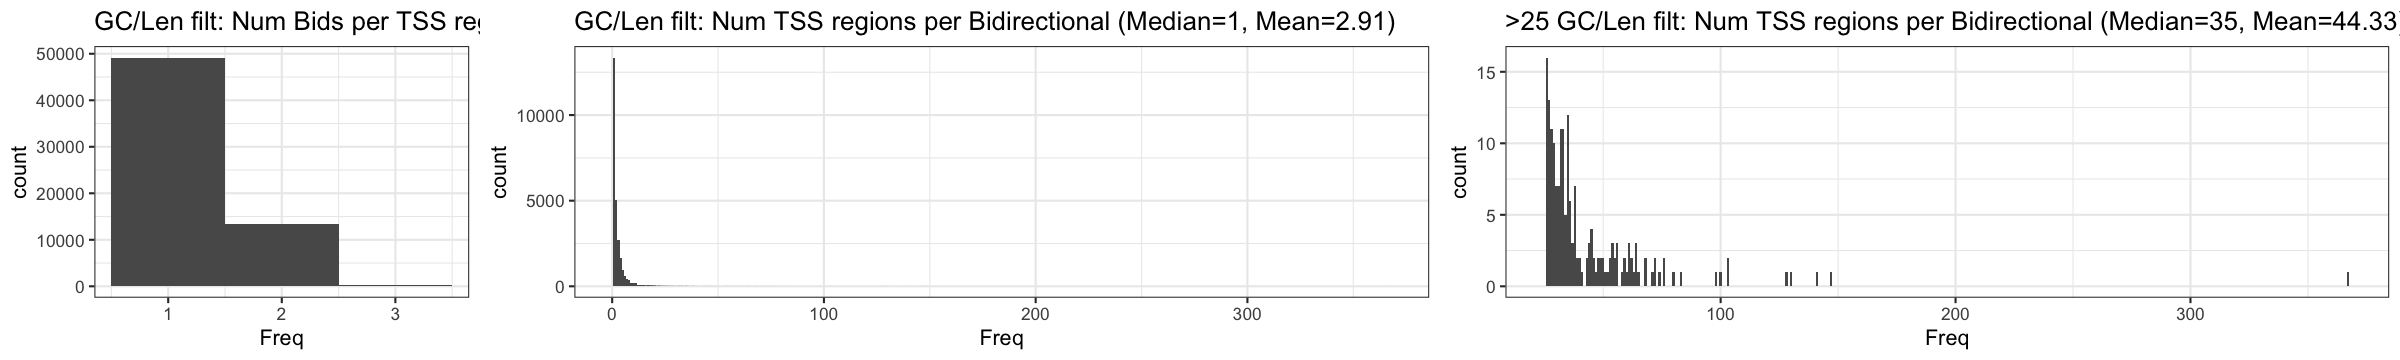

In [75]:
options(repr.plot.height = 3, repr.plot.width = 20)
plot_grid(p1, p2, p3, nrow=1, rel_widths=c(0.5,1,1))

In [76]:
# add a unique id
overlaps_filt$unique_id <- paste0(overlaps_filt$TranscriptID, ":", overlaps_filt$BidID)
# get the fraction of the TSS region overlapped
overlaps_filt$Frac_TSS_overlap <- round(overlaps_filt$overlap/600,5)
# get the fraction of the Bid overlapped
overlaps_filt$Bid_Length <- overlaps_filt$Bid_Stop - overlaps_filt$Bid_Start + 1
overlaps_filt$Frac_Bid_overlap <- round(overlaps_filt$overlap/overlaps_filt$Bid_Length,5)
overlaps_filt[1:2,]

Gene_chr,Gene_Start,Gene_Stop,TranscriptID,Gene_score,strand,GeneID,Gene_Length,Bid_chr,Bid_Start,Bid_Stop,source,BidID,overlap,unique_id,Frac_TSS_overlap,Bid_Length,Frac_Bid_overlap
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<int>,<chr>,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>
chr1,17136,17736,MIR6859-1:NR_106918.1,.,-,MIR6859-1,68,chr1,17003,17329,dREG,chr1-17003-17329-dREG,193,MIR6859-1:NR_106918.1:chr1-17003-17329-dREG,0.32167,327,0.59021
chr1,17136,17736,MIR6859-1:NR_106918.1,.,-,MIR6859-1,68,chr1,17453,17621,Tfit,chr1-17453-17621-Tfit,168,MIR6859-1:NR_106918.1:chr1-17453-17621-Tfit,0.28000,169,0.99408


In [77]:
dim(overlaps_filt)
length(unique(overlaps_filt$TranscriptID))
length(unique(overlaps_filt$BidID))

[1] 77213    18

[1] 63033

[1] 26520

## For repeating transcripts, get the most likely candidate bidirectional according to 3 methods
1. Bidirectional most covered by TSS region
2. Bidirectional that covers most of TSS region
3. Bidirectional w/ mu closest to TSS

In [78]:

# for each transcript with MORE THAN ONE coordinating promoter bidirectional, get one most overlapping
dup_transcripts <- overlaps_filt$TranscriptID[duplicated(overlaps_filt$TranscriptID)]
length(dup_transcripts)
# WITH Top BID overlap
keep_list_filt <- c()
for (transcript in dup_transcripts) {
    # get all overlaps
    filtered <- overlaps_filt[overlaps_filt$TranscriptID == transcript,]
    # order by fraction of TSS region overlapping
    filtered <- filtered[order(-filtered$Frac_Bid_overlap),]
    # add unique id of first
    keep_list_filt <- c(keep_list_filt, filtered$unique_id[1])
    }
# WITH Top TSS overlap
keep_list_filtTSS <- c()
for (transcript in dup_transcripts) {
    # get all overlaps
    filtered <- overlaps_filt[overlaps_filt$TranscriptID == transcript,]
    # order by fraction of TSS region overlapping
    filtered <- filtered[order(-filtered$Frac_TSS_overlap),]
    # add unique id of first
    keep_list_filtTSS <- c(keep_list_filtTSS, filtered$unique_id[1])
    }

# Get distance from mu
overlaps_filt$mu <- (overlaps_filt$Bid_Start + overlaps_filt$Bid_Stop)/2
overlaps_filt$TSS <- (overlaps_filt$Gene_Start + overlaps_filt$Gene_Stop)/2
overlaps_filt$MUDIFF <- abs(overlaps_filt$mu-overlaps_filt$TSS)
overlaps_filt[1:2,]
# WITH Top Mu clsoest
keep_list_filtmu <- c()
for (transcript in dup_transcripts) {
    # get all overlaps
    filtered <- overlaps_filt[overlaps_filt$TranscriptID == transcript,]
    # order by fraction of TSS region overlapping
    filtered <- filtered[order(filtered$MUDIFF),]
    # add unique id of first
    keep_list_filtmu <- c(keep_list_filtmu, filtered$unique_id[1])
    }

[1] 14180

Gene_chr,Gene_Start,Gene_Stop,TranscriptID,Gene_score,strand,GeneID,Gene_Length,Bid_chr,Bid_Start,⋯,source,BidID,overlap,unique_id,Frac_TSS_overlap,Bid_Length,Frac_Bid_overlap,mu,TSS,MUDIFF
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,⋯,<chr>,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr1,17136,17736,MIR6859-1:NR_106918.1,.,-,MIR6859-1,68,chr1,17003,⋯,dREG,chr1-17003-17329-dREG,193,MIR6859-1:NR_106918.1:chr1-17003-17329-dREG,0.32167,327,0.59021,17166,17436,270
chr1,17136,17736,MIR6859-1:NR_106918.1,.,-,MIR6859-1,68,chr1,17453,⋯,Tfit,chr1-17453-17621-Tfit,168,MIR6859-1:NR_106918.1:chr1-17453-17621-Tfit,0.28000,169,0.99408,17537,17436,101


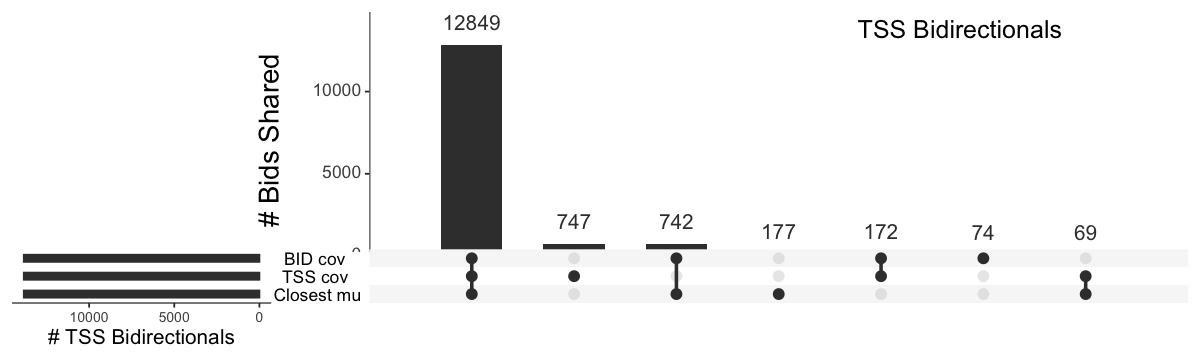

In [79]:
options(repr.plot.height = 3, repr.plot.width =10 )
library(UpSetR)
library(grid)
ListInput <- list("BID cov" = keep_list_filt, 
                  "TSS cov" = keep_list_filtTSS, 
                  "Closest mu" = keep_list_filtmu)
upset(fromList(ListInput), nsets=3,
      order.by = "freq", keep.order=TRUE, sets.x.label= "# TSS Bidirectionals", 
      point.size=3, line.size=1, 
      mainbar.y.label = "# Bids Shared", text.scale = c(2, 1.5, 1.5, 1.2, 1.5, 2))
grid.text("TSS Bidirectionals",x = 0.8, y=0.92, gp=gpar(fontsize=15))

In [80]:
# of ones not shared look at them
c("MIR6859-1:NR_106918.1:chr1-17003-17329-dreg") %in% intersect(keep_list_filt, keep_list_filtTSS)
setdiff(keep_list_filtmu, intersect(keep_list_filt, keep_list_filtTSS))[1:5]
overlaps_filt[overlaps_filt$TranscriptID %in% c("UTS2:NM_021995.2", "FAM131C:NM_182623.3"),]

[1] FALSE

[1] "MIR6859-1:NR_106918.1:chr1-17453-17621-Tfit"     
[2] "MIR200A:NR_029834.1:chr1-1167979-1168291-dREG"   
[3] "RNF207-AS1:NR_125997.1:chr1-6205919-6206165-Tfit"
[4] "RNF207:NM_207396.3:chr1-6205919-6206165-Tfit"    
[5] "CAMTA1:NM_001349609.2:chr1-6784948-6785430-Tfit"

Gene_chr,Gene_Start,Gene_Stop,TranscriptID,Gene_score,strand,GeneID,Gene_Length,Bid_chr,Bid_Start,⋯,source,BidID,overlap,unique_id,Frac_TSS_overlap,Bid_Length,Frac_Bid_overlap,mu,TSS,MUDIFF
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,⋯,<chr>,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr1,7853191,7853791,UTS2:NM_021995.2,.,-,UTS2,5880,chr1,7852650,⋯,Tfit,chr1-7852650-7853410-Tfit,219,UTS2:NM_021995.2:chr1-7852650-7853410-Tfit,0.36500,761,0.28778,7853030,7853491,461
chr1,7853191,7853791,UTS2:NM_021995.2,.,-,UTS2,5880,chr1,7853688,⋯,Tfit,chr1-7853688-7853904-Tfit,103,UTS2:NM_021995.2:chr1-7853688-7853904-Tfit,0.17167,217,0.47465,7853796,7853491,305
chr1,16073351,16073951,FAM131C:NM_182623.3,.,-,FAM131C,15883,chr1,16073593,⋯,Tfit,chr1-16073593-16073745-Tfit,152,FAM131C:NM_182623.3:chr1-16073593-16073745-Tfit,0.25333,153,0.99346,16073669,16073651,18
chr1,16073351,16073951,FAM131C:NM_182623.3,.,-,FAM131C,15883,chr1,16073745,⋯,Tfit,chr1-16073745-16073955-Tfit,206,FAM131C:NM_182623.3:chr1-16073745-16073955-Tfit,0.34333,211,0.97630,16073850,16073651,199


In [81]:
# how many of the duplicated genes are assigned to a non-long isoform and therefore would have implications in the gene-centric stats
# read in long isoforms
long <- fread("../data/processed_annotations/hg38_refseq_prim_chrom_longisof_transcripts.bed")
long[1:2,]
# how many of the duplicated genes are NOT longest isoforms
length(overlaps_filt$TranscriptID[duplicated(overlaps_filt$TranscriptID)])
length(setdiff(overlaps_filt$TranscriptID[duplicated(overlaps_filt$TranscriptID)],long$V4))

V1,V2,V3,V4,V5,V6,V7,V8
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>
chr1,11873,14409,DDX11L1:NR_046018.2,.,+,DDX11L1,2536
chr1,14361,29370,WASH7P:NR_024540.1,.,-,WASH7P,15009


[1] 14180

[1] 10308

In [82]:
# check lengths
length(keep_list_filt)

print("Filt")
non_dup <- overlaps_filt[!overlaps_filt$TranscriptID %in% overlaps_filt$TranscriptID[duplicated(overlaps_filt$TranscriptID)],]
dim(non_dup)
dup <- overlaps_filt[overlaps_filt$unique_id %in% keep_list_filtmu,]
dim(dup)
tss_filt <- rbind(dup, non_dup)
dim(tss_filt)
                        

[1] 14180

[1] "Filt"


[1] 49196    21

[1] 13837    21

[1] 63033    21

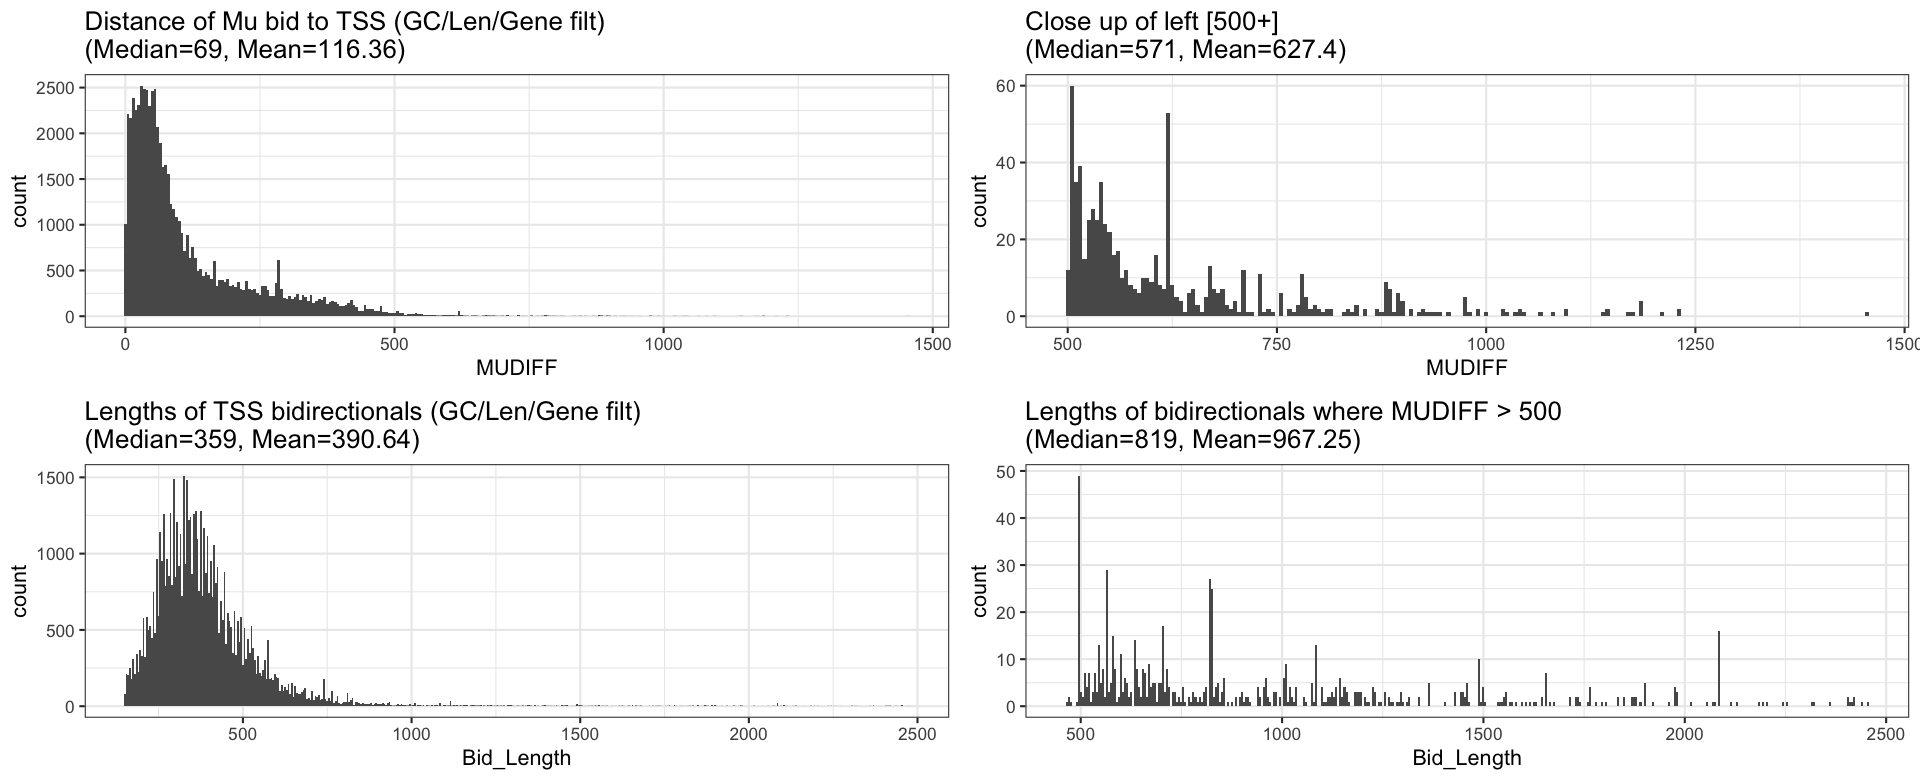

In [87]:
# graph the final distances to mu
options(repr.plot.height = 6.5, repr.plot.width = 16)
p1 <- ggplot(tss_filt, aes(x=MUDIFF)) + geom_histogram(binwidth=5) + 
ggtitle(paste0("Distance of Mu bid to TSS (GC/Len/Gene filt) \n(Median=",median(tss_filt$MUDIFF), 
               ", Mean=", round(mean(tss_filt$MUDIFF),2),")")) + theme_bw(base_size=13)
p2 <- ggplot(tss_filt[tss_filt$MUDIFF > 500], aes(x=MUDIFF)) + geom_histogram(binwidth=5) + 
ggtitle(paste0("Close up of left [500+] \n(Median=",median(tss_filt[tss_filt$MUDIFF > 500]$MUDIFF), 
               ", Mean=", round(mean(tss_filt[tss_filt$MUDIFF > 500]$MUDIFF),2),")")) + theme_bw(base_size=13)
p3 <- ggplot(tss_filt, aes(x=Bid_Length)) + geom_histogram(binwidth=5) + 
ggtitle(paste0("Lengths of TSS bidirectionals (GC/Len/Gene filt) \n(Median=",median(tss_filt$Bid_Length), 
               ", Mean=", round(mean(tss_filt$Bid_Length),2),")")) + theme_bw(base_size=13)
p4 <- ggplot(tss_filt[tss_filt$MUDIFF > 500], aes(x=Bid_Length)) + geom_histogram(binwidth=5) + 
ggtitle(paste0("Lengths of bidirectionals where MUDIFF > 500 \n(Median=",median(tss_filt[tss_filt$MUDIFF > 500]$Bid_Length), 
               ", Mean=", round(mean(tss_filt[tss_filt$MUDIFF > 500]$Bid_Length),2),")")) + theme_bw(base_size=13)
plot_grid(p1, p2, p3, p4, nrow=2)

The distance of mu of the bidirectional from the TSS can range with distances as high as above 1kb. This can be explained by the bidirectionals being substantially long as seen in the bottom right. Notably, these bidirectionals still were closest to mu.

In [88]:
# ccheck out those that are above 1000
test <- tss_filt[tss_filt$MUDIFF > 500]
dim(test)
length(intersect(long$V4, test$TranscriptID))
dim(tss_filt[tss_filt$MUDIFF > 1000])
length(intersect(long$V4, tss_filt[tss_filt$MUDIFF > 1000]$TranscriptID))
#tss_filt[tss_filt$MUDIFF > 1000]

[1] 743  21

[1] 321

[1] 24 21

[1] 19

In [89]:
dim(tss_filt)
long[1:2,]
tss_filt[1:2,]
length(intersect(tss_filt$TranscriptID, long$V4))
length(intersect(tss_filt$TranscriptID, overlaps_filt$TranscriptID))
length(intersect(long$V4, overlaps_filt$TranscriptID))

[1] 63033    21

V1,V2,V3,V4,V5,V6,V7,V8
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>
chr1,11873,14409,DDX11L1:NR_046018.2,.,+,DDX11L1,2536
chr1,14361,29370,WASH7P:NR_024540.1,.,-,WASH7P,15009


Gene_chr,Gene_Start,Gene_Stop,TranscriptID,Gene_score,strand,GeneID,Gene_Length,Bid_chr,Bid_Start,⋯,source,BidID,overlap,unique_id,Frac_TSS_overlap,Bid_Length,Frac_Bid_overlap,mu,TSS,MUDIFF
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,⋯,<chr>,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr1,17136,17736,MIR6859-1:NR_106918.1,.,-,MIR6859-1,68,chr1,17453,⋯,Tfit,chr1-17453-17621-Tfit,168,MIR6859-1:NR_106918.1:chr1-17453-17621-Tfit,0.28000,169,0.99408,17537,17436,101
chr1,297204,297804,LOC127239154:NR_182074.1,.,-,LOC127239154,34786,chr1,297077,⋯,dREG,chr1-297077-297529-dREG,325,LOC127239154:NR_182074.1:chr1-297077-297529-dREG,0.54167,453,0.71744,297303,297504,201


[1] 18262

[1] 63033

[1] 18262

In [91]:
nrow(long)
length(intersect(tss_filt$TranscriptID, long$V4))/nrow(long)

[1] 28889

[1] 0.6321437

63% of the Long isoforms have a TSS assigned to them. 

## Save final TSS bidirectionals used

In [92]:
tss_filt[1:2,]
colnames(tss_filt)
tss_filt <- tss_filt[,c("Gene_chr", "TranscriptID", "strand", "GeneID", "BidID", "Frac_TSS_overlap", "Frac_Bid_overlap", "mu", "TSS", "MUDIFF")]
tss_filt[1:2,]

Gene_chr,Gene_Start,Gene_Stop,TranscriptID,Gene_score,strand,GeneID,Gene_Length,Bid_chr,Bid_Start,⋯,source,BidID,overlap,unique_id,Frac_TSS_overlap,Bid_Length,Frac_Bid_overlap,mu,TSS,MUDIFF
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,⋯,<chr>,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr1,17136,17736,MIR6859-1:NR_106918.1,.,-,MIR6859-1,68,chr1,17453,⋯,Tfit,chr1-17453-17621-Tfit,168,MIR6859-1:NR_106918.1:chr1-17453-17621-Tfit,0.28000,169,0.99408,17537,17436,101
chr1,297204,297804,LOC127239154:NR_182074.1,.,-,LOC127239154,34786,chr1,297077,⋯,dREG,chr1-297077-297529-dREG,325,LOC127239154:NR_182074.1:chr1-297077-297529-dREG,0.54167,453,0.71744,297303,297504,201


[1] "Gene_chr"         "Gene_Start"       "Gene_Stop"        "TranscriptID"    
 [5] "Gene_score"       "strand"           "GeneID"           "Gene_Length"     
 [9] "Bid_chr"          "Bid_Start"        "Bid_Stop"         "source"          
[13] "BidID"            "overlap"          "unique_id"        "Frac_TSS_overlap"
[17] "Bid_Length"       "Frac_Bid_overlap" "mu"               "TSS"             
[21] "MUDIFF"

Gene_chr,TranscriptID,strand,GeneID,BidID,Frac_TSS_overlap,Frac_Bid_overlap,mu,TSS,MUDIFF
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr1,MIR6859-1:NR_106918.1,-,MIR6859-1,chr1-17453-17621-Tfit,0.28000,0.99408,17537,17436,101
chr1,LOC127239154:NR_182074.1,-,LOC127239154,chr1-297077-297529-dREG,0.54167,0.71744,297303,297504,201


In [93]:
colnames(tss_filt) <- c("chr", "TranscriptID", "strand", "GeneID", "BidID", "Frac_TSS_overlap", "Frac_Bid_overlap", "mu", "TSS", "MUDIFF")
write.table(tss_filt, "../data/processed_annotations/tss_bids_08-14-23.txt", 
            row.names=FALSE, sep="\t", quote=FALSE)